# Optimized DeepFake Detection with Batch Processing

This notebook contains optimized code for evaluating a deepfake detection model on a large dataset using batch processing to avoid memory overflow issues.

In [1]:
# Install required packages
!pip install -q insightface opencv-python-headless
!pip install -q onnxruntime-gpu insightface

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.5/439.5 kB 7.5 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.8/280.8 MB 5.8 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 5.2 MB/s eta 0:00:00


In [2]:
import os
import cv2
import torch
import torch.nn as nn
import numpy as np
import timm
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, roc_curve, auc, confusion_matrix
from tqdm import tqdm
import pandas as pd
from torch.utils.data import TensorDataset, DataLoader
from torchvision import transforms
import random
from insightface.app import FaceAnalysis
from PIL import Image
import gc  # For garbage collection

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.6' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
# Function to parse test.txt
def parse_test_file(test_file):
    """Parse test.txt file into a list of (label, video_path) tuples"""
    labels = []
    vid_paths = []
    with open(test_file, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) >= 2:
                label = parts[0]
                video_path = parts[1]
                labels.append(label)
                vid_paths.append(video_path)
    return vid_paths, labels

In [5]:
# Load test data
TEST_FILE_PATH = '/kaggle/input/celeb-df-v2/List_of_testing_videos.txt'
X_path, y = parse_test_file(TEST_FILE_PATH)
print('Number of testing videos:', len(X_path))

Number of testing videos: 518


In [6]:
# Update paths
base_folder = '/kaggle/input/celeb-df-v2/'
X_path = [os.path.join(base_folder, x) for x in X_path]
print(f"Sample video path: {X_path[0]}")

Sample video path: /kaggle/input/celeb-df-v2/YouTube-real/00170.mp4


In [7]:
# Define the model architecture
class XceptionDeepfakeDetector(nn.Module):
    """Xception-based deepfake detection model"""
    
    def __init__(self, num_classes=2, pretrained=True):
        super(XceptionDeepfakeDetector, self).__init__()
        
        # Load pretrained Xception model
        self.xception = timm.create_model('xception', pretrained=True)
        
        # Remove the original classifier
        in_features = self.xception.fc.in_features
        self.xception.fc = nn.Identity()
        
        # Add custom classifier
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(in_features, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        x = self.xception(x)
        x = self.classifier(x)
        return x

In [8]:
# Function to load model checkpoint
def load_checkpoint(model, checkpoint_path):
    """Load model from checkpoint"""
    if not os.path.exists(checkpoint_path):
        raise FileNotFoundError(f"Checkpoint not found at {checkpoint_path}")
    
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"Model loaded from {checkpoint_path}")
    print(f"Checkpoint info - Epoch: {checkpoint['epoch']}, Accuracy: {checkpoint['acc']:.4f}, Loss: {checkpoint['loss']:.4f}")
    
    return model, checkpoint

In [9]:
# Load model
checkpoint_path = '/kaggle/input/deepfakedetection/pytorch/default/1/deepfake_detector_final_epoch_10.pth'
model = XceptionDeepfakeDetector(num_classes=2)
model, checkpoint = load_checkpoint(model, checkpoint_path)
model = model.to(device)

/usr/local/lib/python3.11/dist-packages/timm/models/_factory.py:126: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-cadene/xception-43020ad28.pth" to /root/.cache/torch/hub/checkpoints/xception-43020ad28.pth
/tmp/ipykernel_31/2778340786.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the 

Model loaded from /kaggle/input/deepfakedetection/pytorch/default/1/deepfake_detector_final_epoch_10.pth
Checkpoint info - Epoch: 10, Accuracy: 0.9912, Loss: 0.0625


## Optimized Batch Processing and Evaluation

In [10]:
# OPTIMIZED: Process and evaluate videos in batches
def batch_process_and_evaluate(model, video_paths, labels, batch_size=10, 
                               fps_sampling=1, frame_batch_size=32, 
                               target_size=(299, 299), max_faces_per_frame=1):
    """Process videos in batches and evaluate to avoid memory overflow"""
    
    # Initialize face detector once
    face_app = FaceAnalysis(name='buffalo_l', providers=['CUDAExecutionProvider', 'CPUExecutionProvider'])
    face_app.prepare(ctx_id=0, det_size=(512, 512))
    
    # Set up transform
    transform = transforms.Compose([
        transforms.Resize(target_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ])
    
    # Initialize result containers
    all_frame_results = []
    video_results = {}
    
    # Process videos in batches
    num_videos = len(video_paths)
    num_batches = (num_videos + batch_size - 1) // batch_size  # Ceiling division
    
    for batch_idx in range(num_batches):
        print(f"\nProcessing batch {batch_idx+1}/{num_batches}")
        
        # Get batch indices
        start_idx = batch_idx * batch_size
        end_idx = min((batch_idx + 1) * batch_size, num_videos)
        batch_video_paths = video_paths[start_idx:end_idx]
        batch_labels = labels[start_idx:end_idx]
        
        # Process each video in the batch
        batch_face_tensors = []
        batch_video_indices = []
        batch_frame_indices = []  # Track frame indices for each video
        
        for video_idx, video_path in enumerate(batch_video_paths):
            absolute_video_idx = start_idx + video_idx  # Global index across all batches
            
            print(f"[{absolute_video_idx + 1}/{num_videos}] Processing: {os.path.basename(video_path)}")
            
            # Process video
            cap = cv2.VideoCapture(video_path)
            if not cap.isOpened():
                print(f"Failed to open video: {video_path}")
                continue
                
            fps = cap.get(cv2.CAP_PROP_FPS)
            frame_interval = int(fps / fps_sampling) if fps_sampling != 0 else 1
            frame_count = 0
            frame_idx = 0  # Track frame index within this video
            
            while cap.isOpened():
                ret, frame = cap.read()
                if not ret:
                    break
                    
                if frame_count % frame_interval == 0:
                    # Detect faces
                    faces = face_app.get(frame)
                    
                    for i, face in enumerate(faces[:max_faces_per_frame]):
                        bbox = face.bbox.astype(int)
                        x1, y1, x2, y2 = bbox
                        
                        # Crop and resize
                        cropped_face = frame[y1:y2, x1:x2]
                        if cropped_face.size == 0:
                            continue
                            
                        resized_face = cv2.resize(cropped_face, target_size)
                        pil_face = Image.fromarray(resized_face)
                        tensor_face = transform(pil_face)
                        
                        batch_face_tensors.append(tensor_face)
                        batch_video_indices.append(video_idx)
                        batch_frame_indices.append(frame_idx)
                        
                    frame_idx += 1
                    
                frame_count += 1
                
            cap.release()
            
            # Force garbage collection after each video
            gc.collect()
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
        
        # If no faces were detected in this batch, continue to next batch
        if not batch_face_tensors:
            print("No faces detected in this batch of videos.")
            continue
            
        # Create tensor dataset and dataloader
        face_tensors_stack = torch.stack(batch_face_tensors)
        video_indices_tensor = torch.tensor(batch_video_indices)
        frame_indices_tensor = torch.tensor(batch_frame_indices)
        
        dataset = TensorDataset(face_tensors_stack, video_indices_tensor, frame_indices_tensor)
        dataloader = DataLoader(dataset, batch_size=frame_batch_size, shuffle=False)
        
        # Evaluate this batch
        model.eval()
        batch_preds = []
        batch_probs = []
        batch_video_idxs = []
        batch_frame_idxs = []
        
        with torch.no_grad():
            for data in tqdm(dataloader, desc=f"Evaluating batch {batch_idx+1}"):
                images, vid_indices, frame_indices = data
                images = images.to(device)
                
                outputs = model(images)
                _, preds = torch.max(outputs, 1)
                probs = torch.softmax(outputs, dim=1)[:, 1]  # Probability of being fake (class 1)
                
                batch_preds.extend(preds.cpu().numpy())
                batch_probs.extend(probs.cpu().numpy())
                batch_video_idxs.extend(vid_indices.cpu().numpy())
                batch_frame_idxs.extend(frame_indices.cpu().numpy())
                
        # Create batch results dataframe
        batch_frame_results = pd.DataFrame({
            'batch_video_index': batch_video_idxs,
            'frame_index': batch_frame_idxs,
            'predicted_label': batch_preds,
            'fake_probability': batch_probs
        })
        
        # Add global indices and metadata
        batch_frame_results['video_index'] = batch_frame_results['batch_video_index'] + start_idx
        batch_frame_results['video_path'] = batch_frame_results['video_index'].apply(lambda x: video_paths[x])
        batch_frame_results['true_label'] = batch_frame_results['video_index'].apply(lambda x: int(labels[x]))
        
        # Store batch results
        all_frame_results.append(batch_frame_results)
        
        # Process video-level results for this batch
        for i, video_path in enumerate(batch_video_paths):
            absolute_idx = start_idx + i
            video_frames = batch_frame_results[batch_frame_results['batch_video_index'] == i]
            
            if len(video_frames) > 0:
                true_label = int(labels[absolute_idx])
                avg_prob = video_frames['fake_probability'].mean()
                pred_label = int(avg_prob > 0.5)
                
                video_results[video_path] = {
                    'true_label': true_label,
                    'predicted_label': pred_label,
                    'fake_probability': avg_prob,
                    'num_frames': len(video_frames)
                }
            else:
                print(f"Warning: No frames detected for video {video_path}")
        
        # Free memory after processing each batch
        del batch_face_tensors, face_tensors_stack, dataset, dataloader
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
    
    # Combine all batch results
    if all_frame_results:
        frame_results = pd.concat(all_frame_results, ignore_index=True)
    else:
        print("No faces were detected in any video.")
        return None, None, None
    
    # Create video-level DataFrame
    video_df = pd.DataFrame.from_dict(video_results, orient='index')
    video_df.reset_index(inplace=True)
    video_df.rename(columns={'index': 'video_path'}, inplace=True)
    
    # Calculate frame-level metrics
    accuracy = accuracy_score(frame_results['true_label'], frame_results['predicted_label'])
    precision = precision_score(frame_results['true_label'], frame_results['predicted_label'], average='binary')
    
    # Calculate ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(frame_results['true_label'], frame_results['fake_probability'])
    roc_auc = auc(fpr, tpr)
    
    # Calculate EER (Equal Error Rate)
    fnr = 1 - tpr
    eer_threshold = thresholds[np.nanargmin(np.absolute(fnr - fpr))]
    eer = fpr[np.nanargmin(np.absolute(fnr - fpr))]
    
    # Calculate video-level metrics
    video_accuracy = accuracy_score(video_df['true_label'], video_df['predicted_label'])
    video_precision = precision_score(video_df['true_label'], video_df['predicted_label'], average='binary')
    
    # Calculate video-level ROC curve and AUC
    video_fpr, video_tpr, video_thresholds = roc_curve(video_df['true_label'], video_df['fake_probability'])
    video_roc_auc = auc(video_fpr, video_tpr)
    
    # Calculate video-level EER
    video_fnr = 1 - video_tpr
    video_eer = video_fpr[np.nanargmin(np.absolute(video_fnr - video_fpr))]
    
    metrics = {
        'frame_level': {
            'accuracy': accuracy,
            'precision': precision,
            'auc': roc_auc,
            'eer': eer,
            'fpr': fpr,
            'tpr': tpr,
            'thresholds': thresholds
        },
        'video_level': {
            'accuracy': video_accuracy,
            'precision': video_precision,
            'auc': video_roc_auc,
            'eer': video_eer,
            'fpr': video_fpr,
            'tpr': video_tpr,
            'thresholds': video_thresholds
        }
    }
    
    return metrics, frame_results, video_df

In [11]:
# Run the evaluation
print("Processing and evaluating videos in batches...")
metrics, frame_results, video_df = batch_process_and_evaluate(
    model, 
    X_path, 
    y, 
    batch_size=20,       # Process 20 videos at a time
    fps_sampling=1,      # Sample every frame
    frame_batch_size=32, # Batch size for model inference
    target_size=(299, 299),
    max_faces_per_frame=1
)

Processing and evaluating videos in batches...
download_path: /root/.insightface/models/buffalo_l


100%|██████████| 281857/281857 [00:03<00:00, 92323.36KB/s]


Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}, 'CUDAExecutionProvider': {'sdpa_kernel': '0', 'use_tf32': '1', 'fuse_conv_bias': '0', 'prefer_nhwc': '0', 'tunable_op_max_tuning_duration_ms': '0', 'enable_skip_layer_norm_strict_mode': '0', 'tunable_op_tuning_enable': '0', 'tunable_op_enable': '0', 'use_ep_level_unified_stream': '0', 'device_id': '0', 'has_user_compute_stream': '0', 'gpu_external_empty_cache': '0', 'cudnn_conv_algo_search': 'EXHAUSTIVE', 'cudnn_conv1d_pad_to_nc1d': '0', 'gpu_mem_limit': '18446744073709551615', 'gpu_external_alloc': '0', 'gpu_external_free': '0', 'arena_extend_strategy': 'kNextPowerOfTwo', 'do_copy_in_default_stream': '1', 'enable_cuda_graph': '0', 'user_compute_stream': '0', 'cudnn_conv_use_max_workspace': '1'}}
find model: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider'], with o

/usr/local/lib/python3.11/dist-packages/insightface/utils/transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4


[2/518] Processing: 00208.mp4
[3/518] Processing: 00063.mp4
[4/518] Processing: 00024.mp4
[5/518] Processing: 00021.mp4
[6/518] Processing: 00036.mp4
[7/518] Processing: 00202.mp4
[8/518] Processing: 00236.mp4
[9/518] Processing: 00197.mp4
[10/518] Processing: 00133.mp4
[11/518] Processing: 00213.mp4
[12/518] Processing: 00011.mp4
[13/518] Processing: 00095.mp4
[14/518] Processing: 00138.mp4
[15/518] Processing: 00106.mp4
[16/518] Processing: 00194.mp4
[17/518] Processing: 00092.mp4
[18/518] Processing: 00227.mp4
[19/518] Processing: 00244.mp4
[20/518] Processing: 00119.mp4


Evaluating batch 1: 100%|██████████| 10/10 [00:01<00:00,  5.73it/s]



Processing batch 2/26
[21/518] Processing: 00082.mp4


/usr/local/lib/python3.11/dist-packages/insightface/utils/transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4


[22/518] Processing: 00188.mp4
[23/518] Processing: 00076.mp4
[24/518] Processing: 00047.mp4
[25/518] Processing: 00168.mp4
[26/518] Processing: 00207.mp4
[27/518] Processing: 00193.mp4
[28/518] Processing: 00061.mp4
[29/518] Processing: 00023.mp4
[30/518] Processing: 00048.mp4
[31/518] Processing: 00250.mp4
[32/518] Processing: 00251.mp4
[33/518] Processing: 00252.mp4
[34/518] Processing: 00253.mp4
[35/518] Processing: 00254.mp4
[36/518] Processing: 00255.mp4
[37/518] Processing: 00256.mp4
[38/518] Processing: 00257.mp4
[39/518] Processing: 00258.mp4
[40/518] Processing: 00259.mp4


Evaluating batch 2: 100%|██████████| 9/9 [00:01<00:00,  6.72it/s]



Processing batch 3/26
[41/518] Processing: 00260.mp4


/usr/local/lib/python3.11/dist-packages/insightface/utils/transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4


[42/518] Processing: 00261.mp4
[43/518] Processing: 00262.mp4
[44/518] Processing: 00263.mp4
[45/518] Processing: 00264.mp4
[46/518] Processing: 00265.mp4
[47/518] Processing: 00266.mp4
[48/518] Processing: 00267.mp4
[49/518] Processing: 00268.mp4
[50/518] Processing: 00269.mp4
[51/518] Processing: 00270.mp4
[52/518] Processing: 00271.mp4
[53/518] Processing: 00272.mp4
[54/518] Processing: 00273.mp4
[55/518] Processing: 00274.mp4
[56/518] Processing: 00275.mp4
[57/518] Processing: 00276.mp4
[58/518] Processing: 00277.mp4
[59/518] Processing: 00278.mp4
[60/518] Processing: 00279.mp4


Evaluating batch 3: 100%|██████████| 8/8 [00:01<00:00,  6.82it/s]



Processing batch 4/26
[61/518] Processing: 00280.mp4


/usr/local/lib/python3.11/dist-packages/insightface/utils/transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4


[62/518] Processing: 00281.mp4
[63/518] Processing: 00282.mp4
[64/518] Processing: 00283.mp4
[65/518] Processing: 00284.mp4
[66/518] Processing: 00285.mp4
[67/518] Processing: 00286.mp4
[68/518] Processing: 00287.mp4
[69/518] Processing: 00288.mp4
[70/518] Processing: 00289.mp4
[71/518] Processing: id1_0007.mp4
[72/518] Processing: id2_0008.mp4
[73/518] Processing: id3_0001.mp4
[74/518] Processing: id6_0005.mp4
[75/518] Processing: id9_0000.mp4
[76/518] Processing: id11_0008.mp4
[77/518] Processing: id16_0011.mp4
[78/518] Processing: id17_0000.mp4
[79/518] Processing: id35_0008.mp4
[80/518] Processing: id39_0005.mp4


Evaluating batch 4: 100%|██████████| 9/9 [00:01<00:00,  6.72it/s]



Processing batch 5/26
[81/518] Processing: id48_0000.mp4


/usr/local/lib/python3.11/dist-packages/insightface/utils/transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4


[82/518] Processing: id32_0008.mp4
[83/518] Processing: id56_0009.mp4
[84/518] Processing: id54_0007.mp4
[85/518] Processing: id37_0005.mp4
[86/518] Processing: id29_0008.mp4
[87/518] Processing: id43_0006.mp4
[88/518] Processing: id1_0006.mp4
[89/518] Processing: id51_0001.mp4
[90/518] Processing: id31_0007.mp4
[91/518] Processing: id2_0003.mp4
[92/518] Processing: id21_0009.mp4
[93/518] Processing: id50_0003.mp4
[94/518] Processing: id21_0006.mp4
[95/518] Processing: id44_0003.mp4
[96/518] Processing: id36_0006.mp4
[97/518] Processing: id36_0008.mp4
[98/518] Processing: id1_0008.mp4
[99/518] Processing: id45_0003.mp4
[100/518] Processing: id48_0003.mp4


Evaluating batch 5: 100%|██████████| 9/9 [00:01<00:00,  6.42it/s]



Processing batch 6/26
[101/518] Processing: id23_0001.mp4


/usr/local/lib/python3.11/dist-packages/insightface/utils/transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4


[102/518] Processing: id16_0010.mp4
[103/518] Processing: id31_0004.mp4
[104/518] Processing: id35_0000.mp4
[105/518] Processing: id58_0002.mp4
[106/518] Processing: id30_0007.mp4
[107/518] Processing: id12_0005.mp4
[108/518] Processing: id56_0002.mp4
[109/518] Processing: id33_0005.mp4
[110/518] Processing: id29_0009.mp4
[111/518] Processing: id13_0013.mp4
[112/518] Processing: id28_0009.mp4
[113/518] Processing: id36_0000.mp4
[114/518] Processing: id24_0009.mp4
[115/518] Processing: id39_0004.mp4
[116/518] Processing: id27_0008.mp4
[117/518] Processing: id11_0006.mp4
[118/518] Processing: id19_0007.mp4
[119/518] Processing: id37_0009.mp4
[120/518] Processing: id3_0008.mp4


Evaluating batch 6: 100%|██████████| 9/9 [00:01<00:00,  6.76it/s]



Processing batch 7/26
[121/518] Processing: id46_0000.mp4


/usr/local/lib/python3.11/dist-packages/insightface/utils/transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4


[122/518] Processing: id33_0008.mp4
[123/518] Processing: id8_0000.mp4
[124/518] Processing: id16_0007.mp4
[125/518] Processing: id1_0001.mp4
[126/518] Processing: id32_0002.mp4
[127/518] Processing: id19_0005.mp4
[128/518] Processing: id27_0009.mp4
[129/518] Processing: id2_0001.mp4
[130/518] Processing: id13_0011.mp4
[131/518] Processing: id49_0004.mp4
[132/518] Processing: id57_0007.mp4
[133/518] Processing: id26_0008.mp4
[134/518] Processing: id2_0004.mp4
[135/518] Processing: id36_0001.mp4
[136/518] Processing: id0_0001.mp4
[137/518] Processing: id10_0007.mp4
[138/518] Processing: id17_0002.mp4
[139/518] Processing: id4_0004.mp4
[140/518] Processing: id36_0002.mp4


Evaluating batch 7: 100%|██████████| 9/9 [00:01<00:00,  6.66it/s]



Processing batch 8/26
[141/518] Processing: id53_0003.mp4


/usr/local/lib/python3.11/dist-packages/insightface/utils/transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4


[142/518] Processing: id25_0010.mp4
[143/518] Processing: id51_0006.mp4
[144/518] Processing: id22_0000.mp4
[145/518] Processing: id10_0001.mp4
[146/518] Processing: id6_0002.mp4
[147/518] Processing: id12_0000.mp4
[148/518] Processing: id35_0003.mp4
[149/518] Processing: id3_0002.mp4
[150/518] Processing: id31_0003.mp4
[151/518] Processing: id52_0002.mp4
[152/518] Processing: id2_0002.mp4
[153/518] Processing: id44_0001.mp4
[154/518] Processing: id8_0009.mp4
[155/518] Processing: id33_0002.mp4
[156/518] Processing: id50_0000.mp4
[157/518] Processing: id40_0003.mp4
[158/518] Processing: id7_0006.mp4
[159/518] Processing: id53_0007.mp4
[160/518] Processing: id43_0002.mp4


Evaluating batch 8: 100%|██████████| 9/9 [00:01<00:00,  7.17it/s]



Processing batch 9/26
[161/518] Processing: id56_0000.mp4


/usr/local/lib/python3.11/dist-packages/insightface/utils/transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4


[162/518] Processing: id13_0004.mp4
[163/518] Processing: id43_0001.mp4
[164/518] Processing: id20_0008.mp4
[165/518] Processing: id28_0004.mp4
[166/518] Processing: id22_0009.mp4
[167/518] Processing: id53_0000.mp4
[168/518] Processing: id50_0006.mp4
[169/518] Processing: id32_0003.mp4
[170/518] Processing: id32_0006.mp4
[171/518] Processing: id57_0003.mp4
[172/518] Processing: id37_0004.mp4
[173/518] Processing: id28_0007.mp4
[174/518] Processing: id52_0001.mp4
[175/518] Processing: id40_0009.mp4
[176/518] Processing: id51_0005.mp4
[177/518] Processing: id34_0006.mp4
[178/518] Processing: id42_0002.mp4
[179/518] Processing: id1_id0_0007.mp4
[180/518] Processing: id1_id3_0007.mp4


Evaluating batch 9: 100%|██████████| 9/9 [00:01<00:00,  6.87it/s]



Processing batch 10/26
[181/518] Processing: id1_id4_0007.mp4


/usr/local/lib/python3.11/dist-packages/insightface/utils/transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4


[182/518] Processing: id1_id9_0007.mp4
[183/518] Processing: id1_id16_0007.mp4
[184/518] Processing: id1_id17_0007.mp4
[185/518] Processing: id2_id0_0008.mp4
[186/518] Processing: id2_id3_0008.mp4
[187/518] Processing: id2_id9_0008.mp4
[188/518] Processing: id3_id1_0001.mp4
[189/518] Processing: id3_id2_0001.mp4
[190/518] Processing: id3_id4_0001.mp4
[191/518] Processing: id3_id6_0001.mp4
[192/518] Processing: id3_id9_0001.mp4
[193/518] Processing: id3_id16_0001.mp4
[194/518] Processing: id4_id1_0003.mp4
[195/518] Processing: id6_id0_0005.mp4
[196/518] Processing: id6_id1_0005.mp4
[197/518] Processing: id6_id2_0005.mp4
[198/518] Processing: id6_id3_0005.mp4
[199/518] Processing: id6_id16_0005.mp4
[200/518] Processing: id7_id10_0009.mp4


Evaluating batch 10: 100%|██████████| 9/9 [00:01<00:00,  6.67it/s]



Processing batch 11/26
[201/518] Processing: id7_id11_0009.mp4


/usr/local/lib/python3.11/dist-packages/insightface/utils/transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4


[202/518] Processing: id7_id13_0009.mp4
[203/518] Processing: id9_id0_0000.mp4
[204/518] Processing: id9_id1_0000.mp4
[205/518] Processing: id9_id2_0000.mp4
[206/518] Processing: id9_id3_0000.mp4
[207/518] Processing: id9_id6_0000.mp4
[208/518] Processing: id9_id16_0000.mp4
[209/518] Processing: id10_id7_0004.mp4
[210/518] Processing: id10_id11_0004.mp4
[211/518] Processing: id10_id12_0004.mp4
[212/518] Processing: id10_id13_0004.mp4
[213/518] Processing: id10_id7_0001.mp4
[214/518] Processing: id10_id11_0001.mp4
[215/518] Processing: id10_id12_0001.mp4
[216/518] Processing: id10_id13_0001.mp4
[217/518] Processing: id11_id7_0008.mp4
[218/518] Processing: id16_id0_0011.mp4
[219/518] Processing: id16_id1_0011.mp4
[220/518] Processing: id16_id2_0011.mp4


Evaluating batch 11: 100%|██████████| 8/8 [00:01<00:00,  6.72it/s]



Processing batch 12/26
[221/518] Processing: id16_id3_0011.mp4


/usr/local/lib/python3.11/dist-packages/insightface/utils/transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4


[222/518] Processing: id16_id6_0011.mp4
[223/518] Processing: id17_id0_0000.mp4
[224/518] Processing: id17_id1_0000.mp4
[225/518] Processing: id17_id2_0000.mp4
[226/518] Processing: id17_id3_0000.mp4
[227/518] Processing: id17_id6_0000.mp4
[228/518] Processing: id17_id9_0000.mp4
[229/518] Processing: id17_id16_0000.mp4
[230/518] Processing: id16_id20_0000.mp4
[231/518] Processing: id17_id23_0000.mp4
[232/518] Processing: id3_id28_0001.mp4
[233/518] Processing: id35_id32_0007.mp4
[234/518] Processing: id30_id26_0004.mp4
[235/518] Processing: id16_id20_0006.mp4
[236/518] Processing: id4_id20_0001.mp4
[237/518] Processing: id26_id3_0002.mp4
[238/518] Processing: id20_id31_0006.mp4
[239/518] Processing: id6_id23_0001.mp4
[240/518] Processing: id9_id23_0009.mp4


Evaluating batch 12: 100%|██████████| 8/8 [00:01<00:00,  7.71it/s]



Processing batch 13/26
[241/518] Processing: id32_id33_0002.mp4


/usr/local/lib/python3.11/dist-packages/insightface/utils/transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4


[242/518] Processing: id16_id20_0012.mp4
[243/518] Processing: id29_id30_0000.mp4
[244/518] Processing: id3_id20_0008.mp4
[245/518] Processing: id22_id27_0001.mp4
[246/518] Processing: id27_id21_0002.mp4
[247/518] Processing: id29_id35_0000.mp4
[248/518] Processing: id21_id19_0005.mp4
[249/518] Processing: id23_id26_0003.mp4
[250/518] Processing: id30_id35_0009.mp4
[251/518] Processing: id9_id26_0000.mp4
[252/518] Processing: id33_id32_0006.mp4
[253/518] Processing: id30_id34_0003.mp4
[254/518] Processing: id29_id37_0008.mp4
[255/518] Processing: id35_id31_0006.mp4
[256/518] Processing: id37_id34_0008.mp4
[257/518] Processing: id26_id16_0001.mp4
[258/518] Processing: id17_id23_0009.mp4
[259/518] Processing: id6_id20_0007.mp4
[260/518] Processing: id1_id20_0001.mp4


Evaluating batch 13: 100%|██████████| 8/8 [00:01<00:00,  6.61it/s]



Processing batch 14/26
[261/518] Processing: id1_id23_0006.mp4


/usr/local/lib/python3.11/dist-packages/insightface/utils/transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4


[262/518] Processing: id37_id35_0001.mp4
[263/518] Processing: id4_id23_0006.mp4
[264/518] Processing: id17_id26_0006.mp4
[265/518] Processing: id20_id1_0007.mp4
[266/518] Processing: id0_id26_0009.mp4
[267/518] Processing: id38_id33_0005.mp4
[268/518] Processing: id28_id35_0008.mp4
[269/518] Processing: id23_id35_0006.mp4
[270/518] Processing: id6_id28_0002.mp4
[271/518] Processing: id35_id28_0006.mp4
[272/518] Processing: id32_id31_0008.mp4
[273/518] Processing: id38_id34_0004.mp4
[274/518] Processing: id3_id28_0009.mp4
[275/518] Processing: id37_id28_0007.mp4
[276/518] Processing: id1_id20_0002.mp4
[277/518] Processing: id37_id31_0008.mp4
[278/518] Processing: id30_id23_0007.mp4
[279/518] Processing: id28_id26_0000.mp4
[280/518] Processing: id2_id28_0003.mp4


Evaluating batch 14: 100%|██████████| 9/9 [00:01<00:00,  6.77it/s]



Processing batch 15/26
[281/518] Processing: id27_id24_0007.mp4


/usr/local/lib/python3.11/dist-packages/insightface/utils/transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4


[282/518] Processing: id30_id32_0006.mp4
[283/518] Processing: id35_id31_0009.mp4
[284/518] Processing: id4_id21_0004.mp4
[285/518] Processing: id37_id21_0005.mp4
[286/518] Processing: id30_id21_0002.mp4
[287/518] Processing: id16_id23_0011.mp4
[288/518] Processing: id9_id20_0002.mp4
[289/518] Processing: id6_id21_0006.mp4
[290/518] Processing: id20_id19_0002.mp4
[291/518] Processing: id28_id4_0006.mp4
[292/518] Processing: id35_id34_0002.mp4
[293/518] Processing: id35_id26_0003.mp4
[294/518] Processing: id22_id28_0006.mp4
[295/518] Processing: id30_id21_0005.mp4
[296/518] Processing: id24_id20_0009.mp4
[297/518] Processing: id4_id20_0000.mp4
[298/518] Processing: id2_id26_0001.mp4
[299/518] Processing: id21_id6_0005.mp4
[300/518] Processing: id21_id9_0008.mp4


Evaluating batch 15: 100%|██████████| 8/8 [00:01<00:00,  6.73it/s]



Processing batch 16/26
[301/518] Processing: id22_id21_0005.mp4


/usr/local/lib/python3.11/dist-packages/insightface/utils/transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4


[302/518] Processing: id22_id27_0005.mp4
[303/518] Processing: id23_id2_0007.mp4
[304/518] Processing: id23_id3_0009.mp4
[305/518] Processing: id24_id19_0000.mp4
[306/518] Processing: id24_id21_0006.mp4
[307/518] Processing: id24_id26_0009.mp4
[308/518] Processing: id25_id19_0002.mp4
[309/518] Processing: id25_id24_0003.mp4
[310/518] Processing: id27_id21_0008.mp4
[311/518] Processing: id27_id22_0007.mp4
[312/518] Processing: id27_id25_0008.mp4
[313/518] Processing: id28_id3_0004.mp4
[314/518] Processing: id28_id6_0006.mp4
[315/518] Processing: id29_id32_0000.mp4
[316/518] Processing: id29_id37_0009.mp4
[317/518] Processing: id30_id20_0004.mp4
[318/518] Processing: id30_id23_0002.mp4
[319/518] Processing: id32_id33_0004.mp4
[320/518] Processing: id33_id38_0001.mp4


Evaluating batch 16: 100%|██████████| 8/8 [00:01<00:00,  6.80it/s]



Processing batch 17/26
[321/518] Processing: id34_id33_0005.mp4


/usr/local/lib/python3.11/dist-packages/insightface/utils/transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4


[322/518] Processing: id35_id31_0007.mp4
[323/518] Processing: id49_id52_0005.mp4
[324/518] Processing: id9_id2_0006.mp4
[325/518] Processing: id7_id11_0007.mp4
[326/518] Processing: id4_id37_0006.mp4
[327/518] Processing: id37_id38_0009.mp4
[328/518] Processing: id29_id30_0009.mp4
[329/518] Processing: id0_id6_0007.mp4
[330/518] Processing: id0_id16_0004.mp4
[331/518] Processing: id31_id33_0008.mp4
[332/518] Processing: id54_id49_0003.mp4
[333/518] Processing: id0_id1_0000.mp4
[334/518] Processing: id21_id28_0001.mp4
[335/518] Processing: id33_id29_0004.mp4
[336/518] Processing: id28_id0_0009.mp4
[337/518] Processing: id6_id9_0006.mp4
[338/518] Processing: id9_id0_0006.mp4
[339/518] Processing: id26_id2_0005.mp4
[340/518] Processing: id1_id3_0002.mp4


Evaluating batch 17: 100%|██████████| 9/9 [00:01<00:00,  6.65it/s]



Processing batch 18/26
[341/518] Processing: id4_id6_0008.mp4


/usr/local/lib/python3.11/dist-packages/insightface/utils/transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4


[342/518] Processing: id16_id28_0005.mp4
[343/518] Processing: id37_id35_0005.mp4
[344/518] Processing: id19_id20_0004.mp4
[345/518] Processing: id46_id41_0000.mp4
[346/518] Processing: id51_id57_0004.mp4
[347/518] Processing: id29_id37_0005.mp4
[348/518] Processing: id35_id23_0007.mp4
[349/518] Processing: id34_id33_0002.mp4
[350/518] Processing: id1_id3_0006.mp4
[351/518] Processing: id13_id10_0005.mp4
[352/518] Processing: id56_id55_0009.mp4
[353/518] Processing: id25_id28_0010.mp4
[354/518] Processing: id20_id37_0004.mp4
[355/518] Processing: id37_id29_0002.mp4
[356/518] Processing: id56_id54_0007.mp4
[357/518] Processing: id19_id20_0000.mp4
[358/518] Processing: id4_id28_0006.mp4
[359/518] Processing: id53_id58_0005.mp4
[360/518] Processing: id55_id57_0002.mp4


Evaluating batch 18: 100%|██████████| 9/9 [00:01<00:00,  6.86it/s]



Processing batch 19/26
[361/518] Processing: id24_id26_0004.mp4


/usr/local/lib/python3.11/dist-packages/insightface/utils/transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4


[362/518] Processing: id20_id0_0006.mp4
[363/518] Processing: id37_id2_0009.mp4
[364/518] Processing: id30_id26_0006.mp4
[365/518] Processing: id16_id2_0001.mp4
[366/518] Processing: id26_id1_0002.mp4
[367/518] Processing: id30_id6_0007.mp4
[368/518] Processing: id44_id41_0005.mp4
[369/518] Processing: id16_id2_0006.mp4
[370/518] Processing: id1_id16_0004.mp4
[371/518] Processing: id16_id21_0002.mp4
[372/518] Processing: id4_id0_0000.mp4
[373/518] Processing: id8_id0_0002.mp4
[374/518] Processing: id19_id23_0001.mp4
[375/518] Processing: id37_id3_0006.mp4
[376/518] Processing: id9_id16_0007.mp4
[377/518] Processing: id47_id43_0007.mp4
[378/518] Processing: id16_id3_0009.mp4
[379/518] Processing: id26_id28_0002.mp4
[380/518] Processing: id8_id3_0003.mp4


Evaluating batch 19: 100%|██████████| 9/9 [00:01<00:00,  7.21it/s]



Processing batch 20/26
[381/518] Processing: id30_id28_0000.mp4


/usr/local/lib/python3.11/dist-packages/insightface/utils/transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4


[382/518] Processing: id27_id23_0008.mp4
[383/518] Processing: id28_id20_0008.mp4
[384/518] Processing: id1_id2_0002.mp4
[385/518] Processing: id46_id39_0000.mp4
[386/518] Processing: id37_id28_0008.mp4
[387/518] Processing: id0_id3_0007.mp4
[388/518] Processing: id4_id1_0002.mp4
[389/518] Processing: id13_id7_0000.mp4
[390/518] Processing: id50_id53_0000.mp4
[391/518] Processing: id50_id56_0005.mp4
[392/518] Processing: id4_id21_0009.mp4
[393/518] Processing: id23_id3_0004.mp4
[394/518] Processing: id56_id51_0000.mp4
[395/518] Processing: id30_id3_0006.mp4
[396/518] Processing: id28_id20_0006.mp4
[397/518] Processing: id4_id20_0008.mp4
[398/518] Processing: id54_id58_0006.mp4
[399/518] Processing: id53_id57_0005.mp4
[400/518] Processing: id31_id33_0009.mp4


Evaluating batch 20: 100%|██████████| 9/9 [00:01<00:00,  6.52it/s]



Processing batch 21/26
[401/518] Processing: id0_id21_0000.mp4


/usr/local/lib/python3.11/dist-packages/insightface/utils/transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4


[402/518] Processing: id6_id23_0006.mp4
[403/518] Processing: id48_id45_0002.mp4
[404/518] Processing: id46_id45_0001.mp4
[405/518] Processing: id28_id21_0006.mp4
[406/518] Processing: id12_id10_0005.mp4
[407/518] Processing: id54_id56_0000.mp4
[408/518] Processing: id39_id47_0004.mp4
[409/518] Processing: id9_id3_0009.mp4
[410/518] Processing: id35_id16_0007.mp4
[411/518] Processing: id21_id2_0002.mp4
[412/518] Processing: id12_id10_0002.mp4
[413/518] Processing: id10_id13_0007.mp4
[414/518] Processing: id20_id31_0008.mp4
[415/518] Processing: id0_id16_0003.mp4
[416/518] Processing: id0_id16_0007.mp4
[417/518] Processing: id2_id16_0004.mp4
[418/518] Processing: id13_id7_0012.mp4
[419/518] Processing: id37_id1_0002.mp4
[420/518] Processing: id30_id28_0004.mp4


Evaluating batch 21: 100%|██████████| 9/9 [00:01<00:00,  6.68it/s]



Processing batch 22/26
[421/518] Processing: id53_id52_0003.mp4


/usr/local/lib/python3.11/dist-packages/insightface/utils/transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4


[422/518] Processing: id54_id56_0006.mp4
[423/518] Processing: id3_id28_0002.mp4
[424/518] Processing: id37_id4_0000.mp4
[425/518] Processing: id28_id9_0000.mp4
[426/518] Processing: id4_id2_0003.mp4
[427/518] Processing: id25_id21_0005.mp4
[428/518] Processing: id17_id3_0007.mp4
[429/518] Processing: id2_id1_0004.mp4
[430/518] Processing: id3_id9_0003.mp4
[431/518] Processing: id16_id6_0001.mp4
[432/518] Processing: id8_id6_0002.mp4
[433/518] Processing: id17_id16_0007.mp4
[434/518] Processing: id4_id26_0007.mp4
[435/518] Processing: id44_id45_0000.mp4
[436/518] Processing: id0_id1_0005.mp4
[437/518] Processing: id57_id51_0000.mp4
[438/518] Processing: id34_id32_0007.mp4
[439/518] Processing: id32_id31_0006.mp4
[440/518] Processing: id48_id41_0001.mp4


Evaluating batch 22: 100%|██████████| 9/9 [00:01<00:00,  6.39it/s]



Processing batch 23/26
[441/518] Processing: id4_id0_0004.mp4


/usr/local/lib/python3.11/dist-packages/insightface/utils/transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4


[442/518] Processing: id21_id19_0009.mp4
[443/518] Processing: id45_id39_0008.mp4
[444/518] Processing: id31_id30_0009.mp4
[445/518] Processing: id27_id19_0001.mp4
[446/518] Processing: id23_id16_0003.mp4
[447/518] Processing: id58_id57_0008.mp4
[448/518] Processing: id17_id2_0007.mp4
[449/518] Processing: id28_id3_0001.mp4
[450/518] Processing: id23_id35_0009.mp4
[451/518] Processing: id4_id0_0001.mp4
[452/518] Processing: id17_id31_0009.mp4
[453/518] Processing: id48_id47_0008.mp4
[454/518] Processing: id50_id49_0001.mp4
[455/518] Processing: id20_id1_0003.mp4
[456/518] Processing: id16_id3_0010.mp4
[457/518] Processing: id23_id19_0000.mp4
[458/518] Processing: id1_id3_0009.mp4
[459/518] Processing: id43_id40_0005.mp4
[460/518] Processing: id4_id6_0002.mp4


Evaluating batch 23: 100%|██████████| 8/8 [00:01<00:00,  6.94it/s]



Processing batch 24/26
[461/518] Processing: id10_id7_0008.mp4


/usr/local/lib/python3.11/dist-packages/insightface/utils/transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4


[462/518] Processing: id13_id10_0008.mp4
[463/518] Processing: id12_id7_0006.mp4
[464/518] Processing: id6_id2_0008.mp4
[465/518] Processing: id2_id0_0002.mp4
[466/518] Processing: id2_id6_0002.mp4
[467/518] Processing: id30_id28_0006.mp4
[468/518] Processing: id52_id50_0007.mp4
[469/518] Processing: id49_id52_0007.mp4
[470/518] Processing: id51_id50_0008.mp4
[471/518] Processing: id21_id3_0009.mp4
[472/518] Processing: id31_id16_0002.mp4
[473/518] Processing: id25_id28_0003.mp4
[474/518] Processing: id21_id20_0006.mp4
[475/518] Processing: id10_id7_0005.mp4
[476/518] Processing: id38_id30_0006.mp4
[477/518] Processing: id35_id30_0006.mp4
[478/518] Processing: id20_id9_0008.mp4
[479/518] Processing: id25_id23_0010.mp4
[480/518] Processing: id17_id21_0000.mp4


Evaluating batch 24: 100%|██████████| 9/9 [00:01<00:00,  6.97it/s]



Processing batch 25/26
[481/518] Processing: id45_id47_0002.mp4


/usr/local/lib/python3.11/dist-packages/insightface/utils/transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4


[482/518] Processing: id1_id3_0003.mp4
[483/518] Processing: id27_id26_0006.mp4
[484/518] Processing: id44_id42_0001.mp4
[485/518] Processing: id57_id53_0006.mp4
[486/518] Processing: id43_id39_0000.mp4
[487/518] Processing: id35_id16_0004.mp4
[488/518] Processing: id42_id40_0001.mp4
[489/518] Processing: id21_id2_0000.mp4
[490/518] Processing: id37_id21_0000.mp4
[491/518] Processing: id29_id38_0008.mp4
[492/518] Processing: id39_id44_0000.mp4
[493/518] Processing: id9_id6_0005.mp4
[494/518] Processing: id0_id1_0001.mp4
[495/518] Processing: id31_id2_0004.mp4
[496/518] Processing: id38_id34_0003.mp4
[497/518] Processing: id56_id57_0007.mp4
[498/518] Processing: id52_id58_0005.mp4
[499/518] Processing: id28_id4_0000.mp4
[500/518] Processing: id22_id26_0005.mp4


Evaluating batch 25: 100%|██████████| 8/8 [00:01<00:00,  6.74it/s]



Processing batch 26/26
[501/518] Processing: id4_id30_0000.mp4


/usr/local/lib/python3.11/dist-packages/insightface/utils/transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4


[502/518] Processing: id29_id32_0003.mp4
[503/518] Processing: id35_id20_0007.mp4
[504/518] Processing: id1_id2_0007.mp4
[505/518] Processing: id30_id3_0002.mp4
[506/518] Processing: id22_id25_0001.mp4
[507/518] Processing: id39_id44_0008.mp4
[508/518] Processing: id34_id29_0008.mp4
[509/518] Processing: id21_id28_0009.mp4
[510/518] Processing: id30_id4_0001.mp4
[511/518] Processing: id25_id19_0008.mp4
[512/518] Processing: id21_id4_0002.mp4
[513/518] Processing: id17_id28_0001.mp4
[514/518] Processing: id6_id1_0007.mp4
[515/518] Processing: id9_id2_0008.mp4
[516/518] Processing: id8_id5_0008.mp4
[517/518] Processing: id37_id3_0004.mp4
[518/518] Processing: id17_id2_0003.mp4


Evaluating batch 26: 100%|██████████| 8/8 [00:01<00:00,  6.90it/s]


In [12]:
# Display evaluation results
print("\n===== Frame-level Metrics =====")
print(f"Accuracy: {metrics['frame_level']['accuracy']:.4f}")
print(f"Precision: {metrics['frame_level']['precision']:.4f}")
print(f"AUC-ROC: {metrics['frame_level']['auc']:.4f}")
print(f"EER: {metrics['frame_level']['eer']:.4f}")

print("\n===== Video-level Metrics =====")
print(f"Accuracy: {metrics['video_level']['accuracy']:.4f}")
print(f"Precision: {metrics['video_level']['precision']:.4f}")
print(f"AUC-ROC: {metrics['video_level']['auc']:.4f}")
print(f"EER: {metrics['video_level']['eer']:.4f}")


===== Frame-level Metrics =====
Accuracy: 0.9050
Precision: 0.9832
AUC-ROC: 0.9726
EER: 0.0910

===== Video-level Metrics =====
Accuracy: 0.9286
Precision: 1.0000
AUC-ROC: 0.9903
EER: 0.0500


## Plotting Functions

In [20]:
# Function to plot ROC curves
def plot_roc_curves(metrics, save_dir):
    """Plot ROC curves for frame-level and video-level results"""
    plt.figure(figsize=(10, 8))
    plt.plot(metrics['frame_level']['fpr'], metrics['frame_level']['tpr'], 
             label=f'Frame-level ROC (AUC = {metrics["frame_level"]["auc"]:.3f})')
    plt.plot(metrics['video_level']['fpr'], metrics['video_level']['tpr'], 
             label=f'Video-level ROC (AUC = {metrics["video_level"]["auc"]:.3f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.savefig(os.path.join(save_dir, 'roc_curve.png'), dpi=300)
    plt.show()
    #plt.close()
    return plt

In [22]:
# Function to plot confusion matrix
def plot_confusion_matrix(video_df, save_dir):
    """Plot confusion matrix for video-level results"""
    cm = confusion_matrix(video_df['true_label'], video_df['predicted_label'])
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix (Video-level)')
    plt.colorbar()
    classes = ['Real', 'Fake']
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    
    # Add text annotations
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'confusion_matrix.png'), dpi=300)
    plt.show()
    plt.close()
    return plt

In [23]:
# Function to plot probability distribution
def plot_probability_distribution(frame_results, save_dir):
    """Plot probability distribution of fake scores"""
    plt.figure(figsize=(10, 6))
    real_probs = frame_results[frame_results['true_label'] == 0]['fake_probability']
    fake_probs = frame_results[frame_results['true_label'] == 1]['fake_probability']
    
    plt.hist(real_probs, bins=30, alpha=0.5, label='Real', color='blue')
    plt.hist(fake_probs, bins=30, alpha=0.5, label='Fake', color='red')
    plt.xlabel('Fake Probability')
    plt.ylabel('Count')
    plt.title('Distribution of Fake Probabilities')
    plt.legend()
    plt.savefig(os.path.join(save_dir, 'probability_distribution.png'), dpi=300)
    plt.show()
    plt.close()
    return plt

In [16]:
# Function to plot metrics table
def plot_metrics_table(metrics, save_dir):
    """Plot summary metrics table"""
    plt.figure(figsize=(10, 6))
    plt.axis('tight')
    plt.axis('off')
    
    metrics_table = [
        ['Metric', 'Frame-level', 'Video-level'],
        ['Accuracy', f"{metrics['frame_level']['accuracy']:.4f}", f"{metrics['video_level']['accuracy']:.4f}"],
        ['Precision', f"{metrics['frame_level']['precision']:.4f}", f"{metrics['video_level']['precision']:.4f}"],
        ['AUC', f"{metrics['frame_level']['auc']:.4f}", f"{metrics['video_level']['auc']:.4f}"],
        ['EER', f"{metrics['frame_level']['eer']:.4f}", f"{metrics['video_level']['eer']:.4f}"]
    ]
    
    table = plt.table(cellText=metrics_table, loc='center', cellLoc='center', colWidths=[0.3, 0.3, 0.3])
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1, 2)
    plt.savefig(os.path.join(save_dir, 'metrics_summary.png'), dpi=300)
    plt.show()
    plt.close()
    return plt

## Plotting Results

In [17]:
# Create results directory
results_dir = '/kaggle/working/'
os.makedirs(results_dir, exist_ok=True)

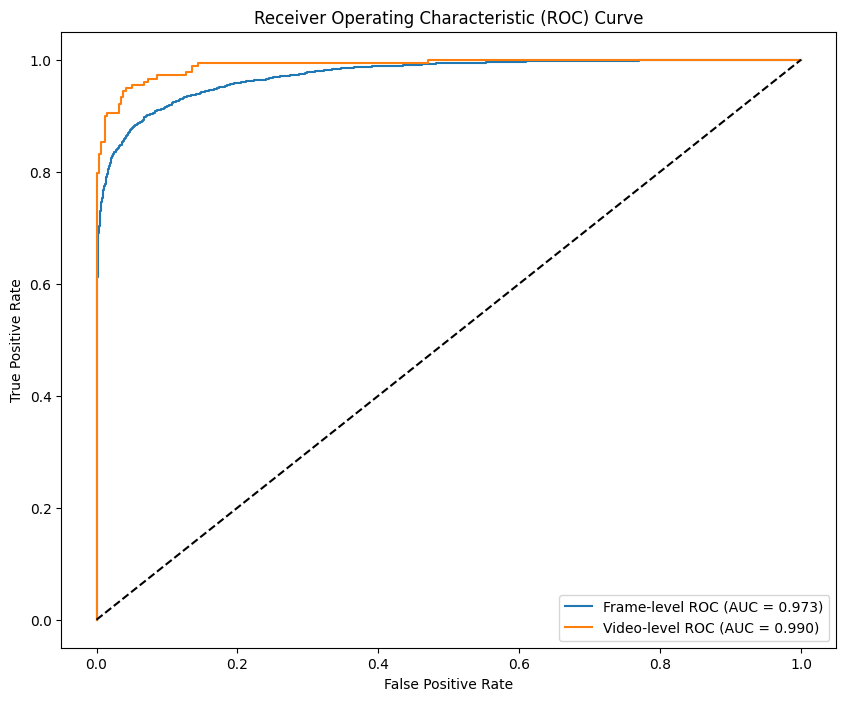

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.11/dist-packages/matplotlib/pyplot.py'>

In [21]:
# Plot ROC curves
plot_roc_curves(metrics, results_dir)

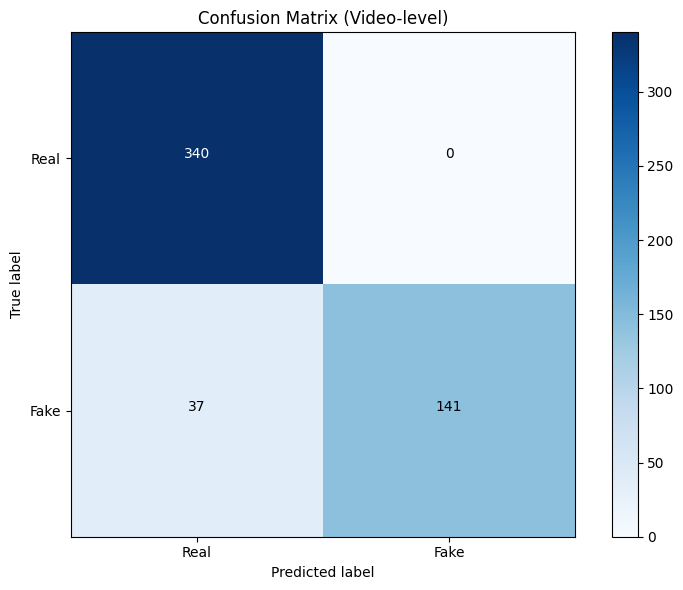

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.11/dist-packages/matplotlib/pyplot.py'>

In [24]:
# Plot confusion matrix
plot_confusion_matrix(video_df, results_dir)

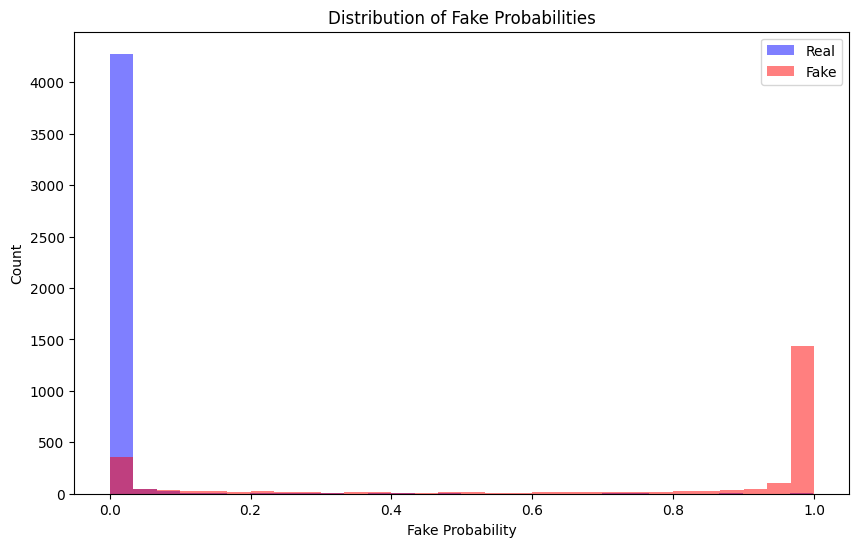

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.11/dist-packages/matplotlib/pyplot.py'>

In [25]:
# Plot probability distribution
plot_probability_distribution(frame_results, results_dir)

In [26]:
# Plot metrics table
plot_metrics_table(metrics, results_dir)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.11/dist-packages/matplotlib/pyplot.py'>

In [27]:
# Save results to CSV for further analysis
frame_results.to_csv(os.path.join(results_dir, 'frame_level_results.csv'), index=False)
video_df.to_csv(os.path.join(results_dir, 'video_level_results.csv'), index=False)

print(f"Results saved to {results_dir}")

Results saved to /kaggle/working/


In [28]:
# Display a sample of frame-level results
print("Sample of frame-level results:")
frame_results.head()

Sample of frame-level results:


,batch_video_index,frame_index,predicted_label,fake_probability,video_index,video_path,true_label
0,0,0,0,0.234021,0,/kaggle/input/celeb-df-v2/YouTube-real/00170.mp4,1
1,0,1,0,0.101906,0,/kaggle/input/celeb-df-v2/YouTube-real/00170.mp4,1
2,0,2,0,0.000876,0,/kaggle/input/celeb-df-v2/YouTube-real/00170.mp4,1
3,0,3,1,0.928045,0,/kaggle/input/celeb-df-v2/YouTube-real/00170.mp4,1
4,0,4,0,0.008321,0,/kaggle/input/celeb-df-v2/YouTube-real/00170.mp4,1


In [29]:
# Display a sample of video-level results
print("Sample of video-level results:")
video_df.head()

Sample of video-level results:


,video_path,true_label,predicted_label,fake_probability,num_frames
0,/kaggle/input/celeb-df-v2/YouTube-real/00170.mp4,1,0,0.108076,12
1,/kaggle/input/celeb-df-v2/YouTube-real/00208.mp4,1,1,0.623633,16
2,/kaggle/input/celeb-df-v2/YouTube-real/00063.mp4,1,1,0.507667,16
3,/kaggle/input/celeb-df-v2/YouTube-real/00024.mp4,1,1,0.998098,19
4,/kaggle/input/celeb-df-v2/YouTube-real/00021.mp4,1,1,0.872144,16
